# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

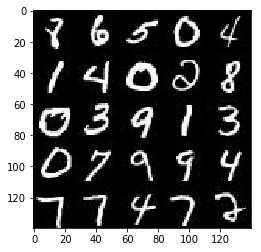

In [30]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

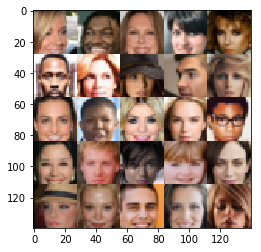

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/arthur_caillau/anaconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32)
    
    return real_input, z_input, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [63]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input Layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(bn2, rate=0.5)
        relu2 = tf.maximum(alpha * dropout2, dropout2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        dropout3 = tf.layers.dropout(bn3, rate=0.5)
        relu3 = tf.maximum(alpha * dropout3, dropout3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=initializer)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.layers.dropout(x1, rate=0.5)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, rate=0.5)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, rate=0.5)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 13, strides=1, padding='valid')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * (1.0 - smooth) 
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    def scale_range (input, min=-1, max=1):
        """
        Scale numpy array `input` in-place
        """
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        
        return input

    samples, losses = [], []
    steps = 0
    
    # Building the NN
    real_input, z_input, lr = model_inputs(
        data_shape[1], 
        data_shape[2], 
        data_shape[3], 
        z_dim
    )
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale batch_images to [-1, 1]
                batch_images = scale_range(batch_images)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 250 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 8.5087
Epoch 1/2... Discriminator Loss: 0.4333... Generator Loss: 3.9237
Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 10.6083
Epoch 1/2... Discriminator Loss: 2.4949... Generator Loss: 0.1984
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 2.1466
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 2.2386
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.9481
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.2068
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 2.9333
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 3.3712


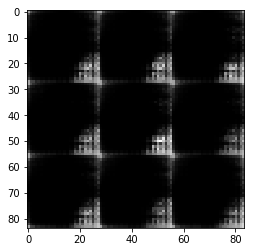

Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 1.1823
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 4.7301
Epoch 1/2... Discriminator Loss: 2.0898... Generator Loss: 0.2976
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.5697
Epoch 1/2... Discriminator Loss: 1.9887... Generator Loss: 0.2995
Epoch 1/2... Discriminator Loss: 1.7944... Generator Loss: 0.3303
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.7232... Generator Loss: 0.4217
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 1.9683


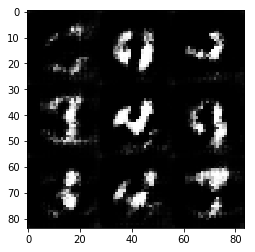

Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 1.8116
Epoch 1/2... Discriminator Loss: 1.8403... Generator Loss: 0.3152
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 1.1555
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 1.5632... Generator Loss: 0.4118
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 3.3427
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 2.0360
Epoch 1/2... Discriminator Loss: 1.5984... Generator Loss: 0.4260


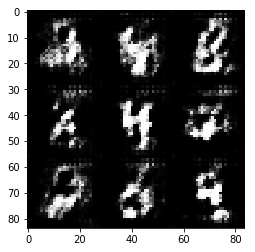

Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.9031
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 1.7726
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 1.9175
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 2.0049
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 3.5241
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 2.1277


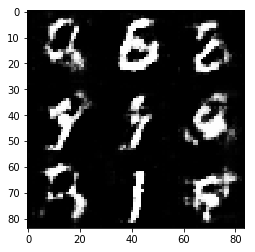

Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 3.6097
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.6999
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 1.5159
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 2.0570
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 2.7880
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.6001


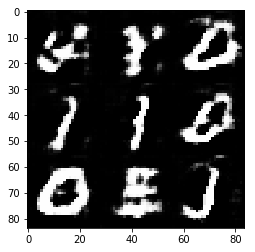

Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 1.2633
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 1.9239
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.9594
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 3.0979
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 0.9918... Generator Loss: 1.9484
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.5773... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 1.1599... Generator Loss: 0.8187


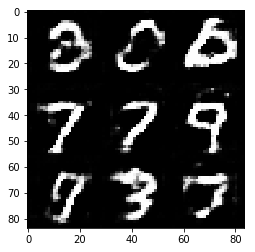

Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 2.1025
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 2.0001
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.4931
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 1.8698
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 3.9282
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 2.9104
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 2.5838


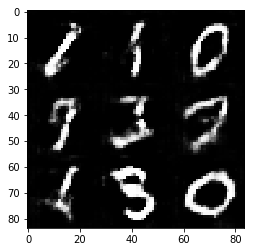

Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 1.3202
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.5464
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 0.7938
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 0.5872... Generator Loss: 1.8045
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.5632


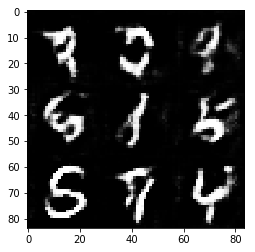

Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 3.3222
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 0.9293
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.5750
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 1.7220
Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 1.7837
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 0.8886... Generator Loss: 2.6719
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 0.8111


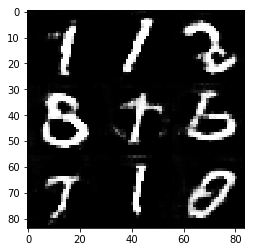

Epoch 1/2... Discriminator Loss: 1.7987... Generator Loss: 0.2999
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 2.1158
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.2756
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 2.2060
Epoch 1/2... Discriminator Loss: 1.6956... Generator Loss: 0.3670
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.5369
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 2.4887
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.1166


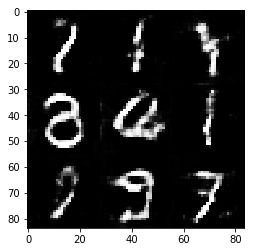

Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 3.7597
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.1630
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 2.9791
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 0.9651
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 2.3551


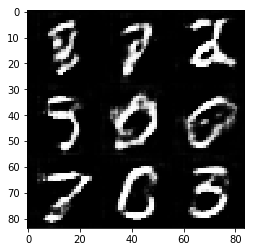

Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 2.0540
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.9516
Epoch 1/2... Discriminator Loss: 1.5306... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.3491
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 1.6422
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 2.7007
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 2.7724... Generator Loss: 0.1569


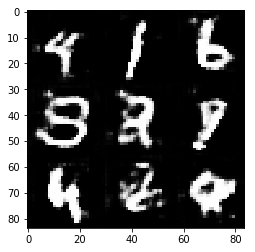

Epoch 1/2... Discriminator Loss: 2.1017... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 1.3457
Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 1.2177
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 2.7588
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.6494... Generator Loss: 3.2174
Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 0.8511
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 1.8883
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.2576


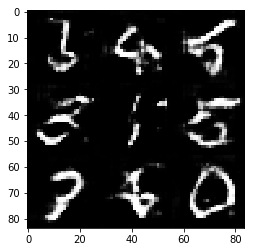

Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 0.9823
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.9005... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 2.2399
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 1.5822
Epoch 1/2... Discriminator Loss: 0.5211... Generator Loss: 2.1247


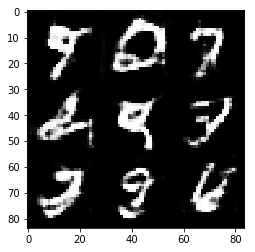

Epoch 1/2... Discriminator Loss: 2.5711... Generator Loss: 5.4875
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 3.0528
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.9644
Epoch 1/2... Discriminator Loss: 1.8725... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 0.6936... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.5474
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.6608


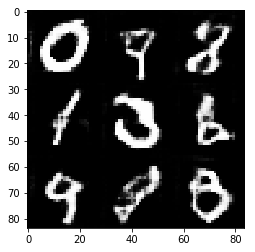

Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 1.9369
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 0.5295... Generator Loss: 2.0323
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.4825
Epoch 1/2... Discriminator Loss: 0.8827... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 0.7013... Generator Loss: 1.4043


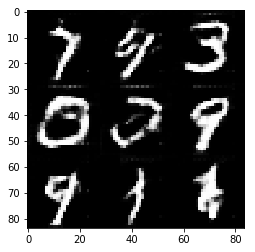

Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.9366
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.7775
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 1.7287
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 1.8343
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.6434... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 0.6137... Generator Loss: 2.0860
Epoch 1/2... Discriminator Loss: 0.4448... Generator Loss: 2.6813
Epoch 1/2... Discriminator Loss: 0.6984... Generator Loss: 2.4273


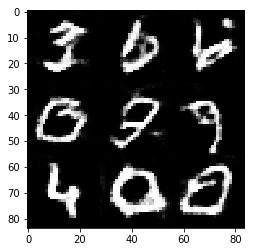

Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.8143
Epoch 1/2... Discriminator Loss: 0.5511... Generator Loss: 1.8139
Epoch 1/2... Discriminator Loss: 2.0631... Generator Loss: 3.4932
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.3372
Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.5548
Epoch 1/2... Discriminator Loss: 0.8159... Generator Loss: 1.1314
Epoch 1/2... Discriminator Loss: 0.7038... Generator Loss: 1.3191
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.0896


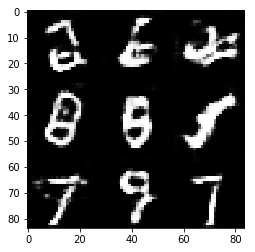

Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.2462
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 1.9937
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.5428
Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 2.5420
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 2.2260
Epoch 1/2... Discriminator Loss: 3.3841... Generator Loss: 0.1172
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.7515... Generator Loss: 2.7727
Epoch 2/2... Discriminator Loss: 1.6707... Generator Loss: 0.4896
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 0.9070


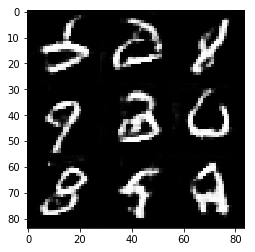

Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.4747
Epoch 2/2... Discriminator Loss: 0.4423... Generator Loss: 2.6234
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.6231
Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 0.5346
Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.2345
Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 2.1731
Epoch 2/2... Discriminator Loss: 0.6130... Generator Loss: 1.6372
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.3032
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 2.0096
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.7169


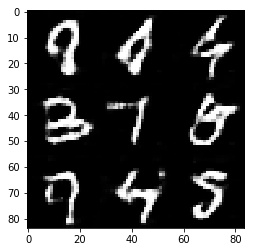

Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 1.9952
Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 2.1705
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 1.7649... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 3.0564
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 2.3561
Epoch 2/2... Discriminator Loss: 0.5312... Generator Loss: 2.0547
Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 1.5345


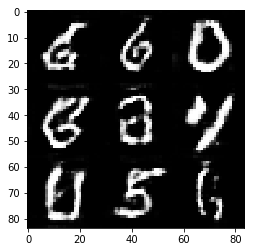

Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 0.9300
Epoch 2/2... Discriminator Loss: 2.9608... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.4411
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 2.4095
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.4141
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 3.1555
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 3.3808
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 4.1458


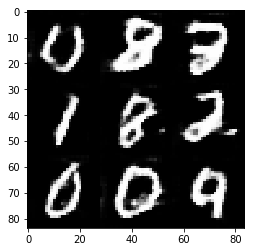

Epoch 2/2... Discriminator Loss: 1.8364... Generator Loss: 0.3281
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.7523
Epoch 2/2... Discriminator Loss: 0.5368... Generator Loss: 1.9620
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.8111
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 3.0453
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 2.1068
Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.6809
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 3.6037
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.7927


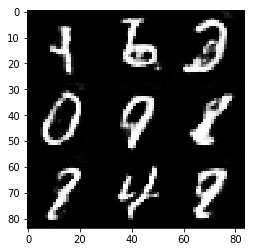

Epoch 2/2... Discriminator Loss: 1.6040... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 1.6716
Epoch 2/2... Discriminator Loss: 0.4990... Generator Loss: 2.0953
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 2.4025
Epoch 2/2... Discriminator Loss: 0.4910... Generator Loss: 2.1724
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 2.0954
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 2.6062
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.9442
Epoch 2/2... Discriminator Loss: 3.2051... Generator Loss: 0.1255


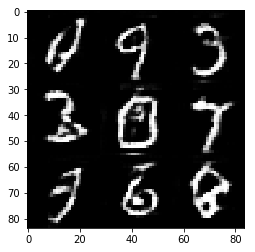

Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.9716
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.4087
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 0.5641... Generator Loss: 1.8183
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.4534
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 0.5328... Generator Loss: 2.2934
Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 3.3114


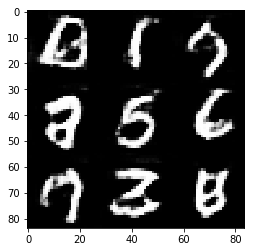

Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 1.6074
Epoch 2/2... Discriminator Loss: 2.2382... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 0.5184... Generator Loss: 2.1506
Epoch 2/2... Discriminator Loss: 0.6010... Generator Loss: 2.4961
Epoch 2/2... Discriminator Loss: 1.9605... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 0.4460... Generator Loss: 2.6111
Epoch 2/2... Discriminator Loss: 1.5112... Generator Loss: 0.4569
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.4498


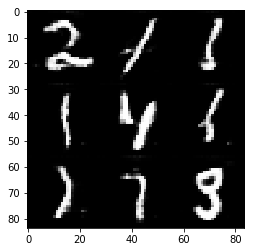

Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 0.5399... Generator Loss: 1.9876
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.5367
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 1.7728
Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 2.4607
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 2.7990
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.6971
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.7546


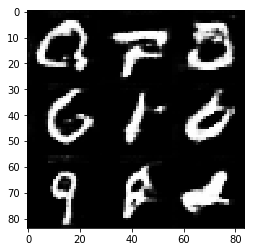

Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.9369
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 0.4304... Generator Loss: 2.9120
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 1.5636
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 2.1436
Epoch 2/2... Discriminator Loss: 1.6666... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 0.5738... Generator Loss: 2.0917


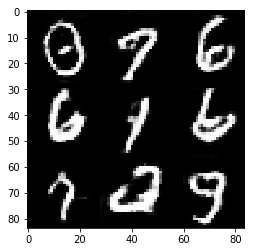

Epoch 2/2... Discriminator Loss: 0.5237... Generator Loss: 2.1800
Epoch 2/2... Discriminator Loss: 0.5452... Generator Loss: 2.2057
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 0.4226... Generator Loss: 2.7619
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 0.7257... Generator Loss: 1.4786
Epoch 2/2... Discriminator Loss: 1.5189... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 1.4841... Generator Loss: 0.6114
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.2332


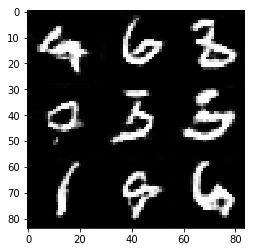

Epoch 2/2... Discriminator Loss: 1.5619... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 1.9804
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.5200
Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 2.2058
Epoch 2/2... Discriminator Loss: 2.4225... Generator Loss: 0.2306
Epoch 2/2... Discriminator Loss: 0.4147... Generator Loss: 2.8531
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 1.3728
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.7228


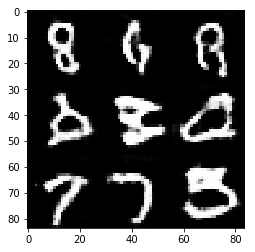

Epoch 2/2... Discriminator Loss: 0.4175... Generator Loss: 2.9052
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 3.8744
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 2.3917
Epoch 2/2... Discriminator Loss: 0.5748... Generator Loss: 2.1599
Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 2.2215
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.8316
Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 2.0149


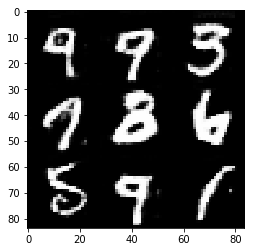

Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 2.2008
Epoch 2/2... Discriminator Loss: 0.5312... Generator Loss: 2.0059
Epoch 2/2... Discriminator Loss: 0.6801... Generator Loss: 1.6331
Epoch 2/2... Discriminator Loss: 0.4677... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 2.0905
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.5946
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 2.0916
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 2.3682


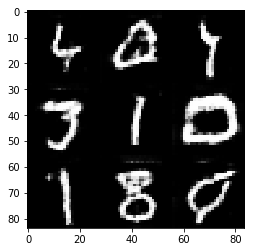

Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.9167
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.9750
Epoch 2/2... Discriminator Loss: 1.4734... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 2.8372
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 0.5733... Generator Loss: 1.8555
Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 1.5515
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 0.4360... Generator Loss: 3.0760


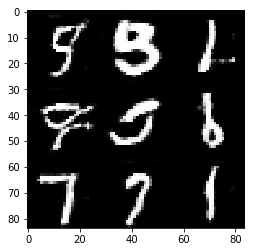

Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 1.4820
Epoch 2/2... Discriminator Loss: 1.5607... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.6620
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.0811
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.9694


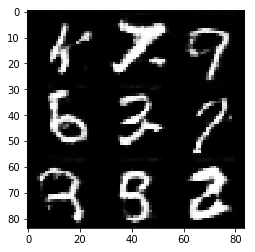

Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 3.8215
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 2.9501
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 2.4423
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 2.4003
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2019
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 2.3348
Epoch 2/2... Discriminator Loss: 0.5447... Generator Loss: 2.0815


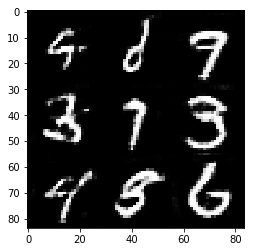

Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.2781
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 0.4257... Generator Loss: 2.8816
Epoch 2/2... Discriminator Loss: 0.5424... Generator Loss: 3.0302
Epoch 2/2... Discriminator Loss: 0.4263... Generator Loss: 2.8735
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 2.2221
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 1.1197
Epoch 2/2... Discriminator Loss: 0.6456... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 1.8304


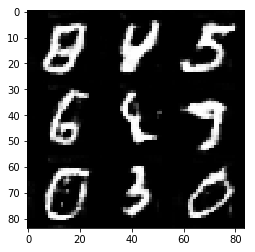

Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.7706
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.2325
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.9516
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.8686
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.5270
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 2.3394
Epoch 2/2... Discriminator Loss: 2.1594... Generator Loss: 0.2606
Epoch 2/2... Discriminator Loss: 2.0520... Generator Loss: 4.2730
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 3.3131
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.0756


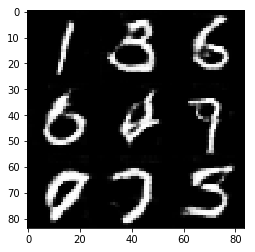

Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.7357
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.6602
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.4649
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.5763


In [69]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        mnist_dataset.get_batches,
        mnist_dataset.shape, 
        mnist_dataset.image_mode
    )

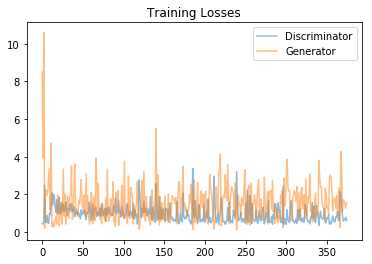

In [70]:
# Plot losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: 1.6928... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 15.0788
Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 14.3136
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 2.7382
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 9.7328
Epoch 1/1... Discriminator Loss: 2.0392... Generator Loss: 12.9094
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 4.9842
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 5.9401
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.3733
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 4.7459
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 6.9826
Epoch 1

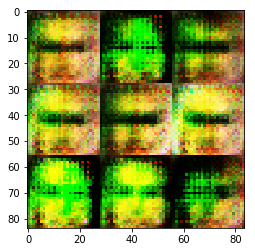

Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.3214
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 3.4026
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 2.7778
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 1.9946
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 2.8607
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 4.5045
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 3.3171
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 4.9500
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 6.7894
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 3.4261
Epoch 1/1.

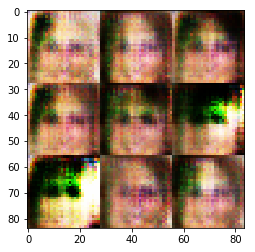

Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.9707
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 2.5999
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 3.3028
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 2.4770
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.8190... Generator Loss: 3.8023
Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 3.2505
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 2.9853
Epoch 1/1... Discriminator Loss: 2.9572... Generator Loss: 5.7279
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.6571
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.9532
Epoch 1/1... Discriminator Loss: 3.1087... Generator Loss: 0.0845
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 2.0472
Epoch 1/1.

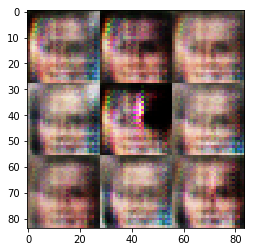

Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.4171
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 3.4944
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 2.6086
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.9248
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.1063
Epoch 1/1.

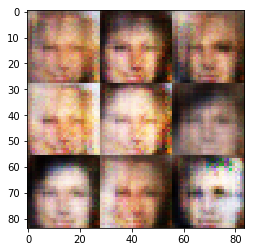

Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.7849... Generator Loss: 3.1583
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.2736
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.6242
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 3.4880
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 2.3719
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.7181
Epoch 1/1.

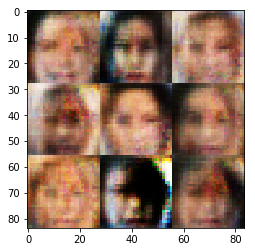

Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 3.9043
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 3.5761
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.6466
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 6.1790
Epoch 1/1... Discriminator Loss: 2.0903... Generator Loss: 4.5466
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.6981
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 3.7714
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 2.3543
Epoch 1/1... Discriminator Loss: 2.2581... Generator Loss: 0.1886
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 5.0390
Epoch 1/1.

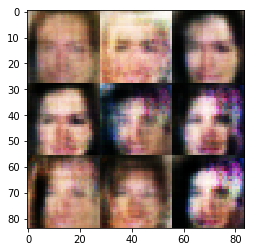

Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 2.1092
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 3.8850
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 4.1413
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 5.2525
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 3.1496
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.9330
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 4.8694
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.3377
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 4.1893
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 3.4619
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 3.0580
Epoch 1/1.

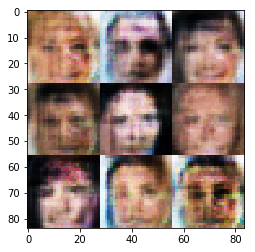

Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.8245... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 2.0722
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.5860
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.3074
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 1.9997
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.6729
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 6.1423
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 4.8346
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 2.4219
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.3135
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 3.1023
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 7.6096
Epoch 1/1.

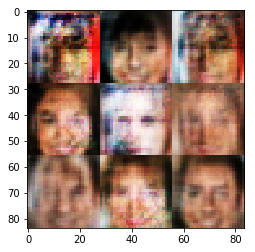

Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 5.2021
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 2.1169
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 4.8129
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.9039
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.9004
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 5.0299
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 3.0923
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 6.3718
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 5.6650
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 5.4959
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.6183
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 4.6783
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 6.1252
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 4.2272
Epoch 1/1.

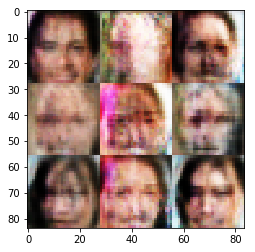

Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.5290
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 2.5745
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 3.9467
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 4.1956
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.0142
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 2.0111
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 5.3623
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.7326
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.1080
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.4457
Epoch 1/1.

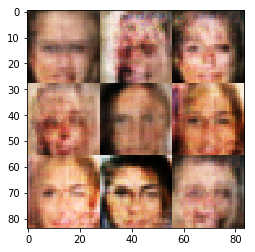

Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 2.3492
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 6.0226
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 3.7610
Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 2.4034
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 4.7564
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.5734
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 4.8053
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 6.6884
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 2.1265
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 6.6936
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 2.8098
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 4.5263
Epoch 1/1.

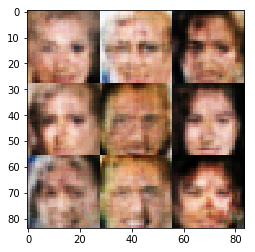

Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.1897
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 2.7507
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.6079
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.8016
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 4.2897
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 6.1992
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 6.6473
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 4.2716
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.9002
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 4.7083
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 3.1740
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 2.4708
Epoch 1/1.

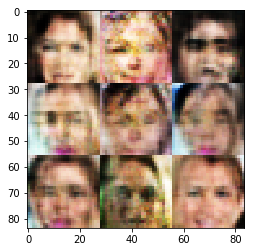

Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.8746
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 4.2108
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 3.7296
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 4.9836
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 3.4439
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 6.2128
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 4.6938
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 5.7377
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 2.0542
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 4.1815
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 5.2182
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.5060
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.4632
Epoch 1/1.

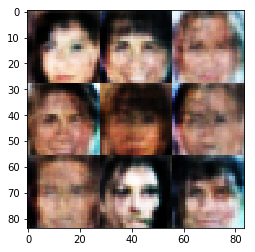

Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 2.0517
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 3.6289
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.9147
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 2.8113
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.4327
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 4.6936
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.3654
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.7822
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 4.5088
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 3.1965
Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 2.9392
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 5.4570
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 2.4725
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.8546
Epoch 1/1.

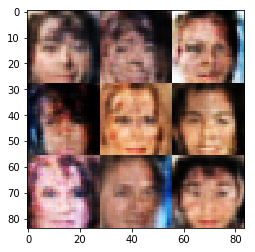

Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.7566
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 3.8887
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 3.2955
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.6323
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 2.9144
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 3.4665
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.9568
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 4.0629
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 3.0847
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 2.4360
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 3.0919
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7562
Epoch 1/1.

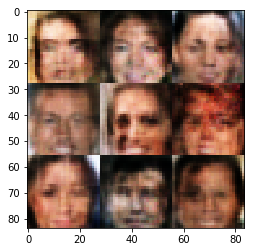

Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 4.4680
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 5.1934
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 3.8844
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 3.2249
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 4.2256
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.2796
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.6089
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 4.8743
Epoch 1/1... Discriminator Loss: 2.5261... Generator Loss: 0.2157
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.6571
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 2.4811
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 5.1543
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 5.0035
Epoch 1/1.

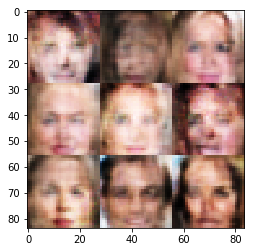

Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 4.5225
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 5.7232
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 2.2138
Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 4.4944
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 5.3758
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 3.1087
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 6.0993
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 4.6172
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.7052
Epoch 1/1... Discriminator Loss: 1.8709... Generator Loss: 4.3584
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 6.3767
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.3017
Epoch 1/1.

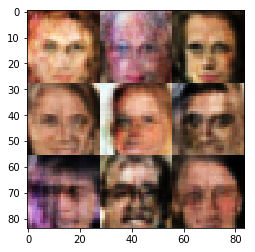

Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 3.4233
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 4.7261
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 4.6740
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 6.2689
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 5.5702
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.5692
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 2.5434
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 2.5871
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 2.9963
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 6.5021
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9190
Epoch 1/1.

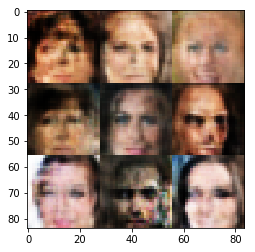

Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 3.5499
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 7.3823
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 3.3060
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 4.0796
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 3.8849
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 2.1565
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.9681
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 3.0843
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 2.5783
Epoch 1/1.

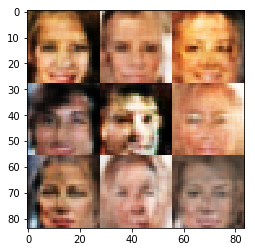

Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 5.2288
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 4.5116
Epoch 1/1... Discriminator Loss: 2.1744... Generator Loss: 0.2416
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.3535
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 4.0670
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 2.3183
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.9081
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 4.2736
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.8942... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 2.0349
Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 3.3240
Epoch 1/1.

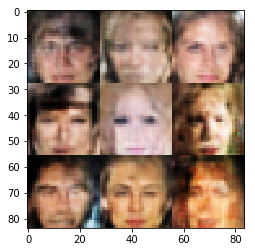

Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 3.2297
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 2.6121
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 0.6132... Generator Loss: 2.0798
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 3.4377
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 2.1934
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 2.2068
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 5.3521
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 5.4160
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.1366
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 3.5209
Epoch 1/1.

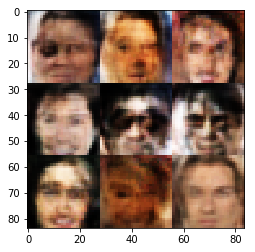

Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 2.2718
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 7.0226
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 4.2403
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 4.8894
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.6237
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 2.0711
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 4.2093
Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 3.0008
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 3.3588
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 5.7810
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 4.6489
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.8047
Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 4.8686
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 3.2933
Epoch 1/1.

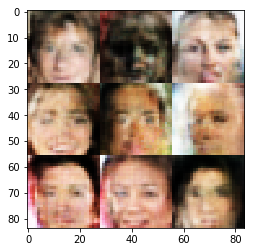

Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 6.3630
Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 3.4277
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 2.7263
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 3.7697
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.0056
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 3.1135
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 2.6178
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 2.7529
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 3.1927
Epoch 1/1.

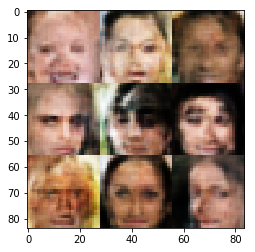

Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 3.7143
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 5.5107
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 4.8167
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 3.5342
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.5725
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 3.0026
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 3.7242
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 2.9725
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.5639
Epoch 1/1.

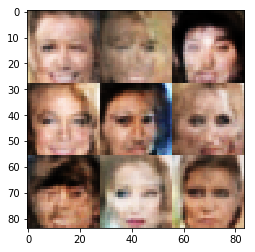

Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 4.7982
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 3.2019
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.9475
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.4078
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.6777
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 2.1326
Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 3.5553
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 6.3693
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 3.3159
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 4.6930
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 2.2307
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 4.2913
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 4.7568
Epoch 1/1.

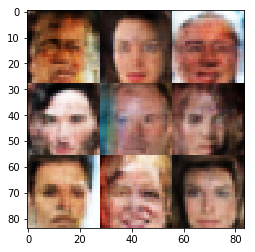

Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 3.3985
Epoch 1/1... Discriminator Loss: 1.9784... Generator Loss: 0.3218
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 2.6629
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 4.2891
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.8891
Epoch 1/1... Discriminator Loss: 1.9961... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.4105
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.3068


In [74]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        celeba_dataset.get_batches,
        celeba_dataset.shape, 
        celeba_dataset.image_mode
    )

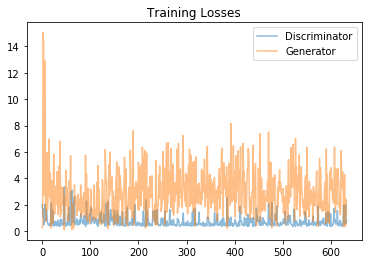

In [75]:
# Plot losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.